<a href="https://colab.research.google.com/github/davidmorme/Universidad/blob/main/Diversi%C3%B3n/Movies_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este Notebook está basado en un tutorial de DataCamp en el link https://www.datacamp.com/community/tutorials/streaming-platform-analysis

La base de datos se encuentra en: https://www.kaggle.com/ruchi798/movies-on-netflix-prime-video-hulu-and-disney

Let's describe data attributes in detail:

ID: It is a unique ID for each record.

Title: It is the name of the movie

Year: Release year of the movie.

Age: it is the target age group

IMDb: IMDB rating of movies.

Rotten Tomatoes: Rotten Tomatoes %

Netflix: whether the movie is found on Netflix

Hulu: whether the movie is found on Hulu

Prime Video: whether the movie is found on Prime Video

Disney+: whether the movie is found on Disney+

Type: Movie or TV show

Directors: Name of the director

Genres: Type of genre

Country: Country of origin

Language: Language of origin

Runtime: Duration of the movie

# **Análisis de la base de datos**

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer    
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn import preprocessing
from scipy.sparse import hstack
import pandas_profiling

In [ ]:
df=pd.read_csv('MoviesOnStreamingPlatforms_updated.csv', index_col=0)
df.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,18+,7.8/10,98/100,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2,Dangal,2016,7+,8.4/10,97/100,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,5,Roma,2018,18+,7.7/10,94/100,1,0,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 0 to 9514
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9515 non-null   int64  
 1   Title            9515 non-null   object 
 2   Year             9515 non-null   int64  
 3   Age              5338 non-null   object 
 4   IMDb             9309 non-null   object 
 5   Rotten Tomatoes  9508 non-null   object 
 6   Netflix          9515 non-null   int64  
 7   Hulu             9515 non-null   int64  
 8   Prime Video      9515 non-null   int64  
 9   Disney+          9515 non-null   int64  
 10  Type             9515 non-null   int64  
 11  Directors        9104 non-null   object 
 12  Genres           9399 non-null   object 
 13  Country          9261 non-null   object 
 14  Language         9202 non-null   object 
 15  Runtime          9196 non-null   float64
dtypes: float64(1), int64(7), object(8)
memory usage: 1.2+ MB


In [ ]:
df.Type.unique() #Se ve que solo hay 0s en la columna de Type

array([0])

In [ ]:
#df.isnull() #Me dice si cada uno de los valores es nulo del data frame en True or False
#df.isnull().sum() #Me da la suma de los valores nulos en cada columna que tiene el data frame
#pd.DataFrame(df.isnull().sum()) #Me guarda exactamente la misma información pero en un data frame 

In [ ]:
#Finding Missing values in all columns
miss = pd.DataFrame(df.isnull().sum()) #Me guarda la suma de los valores nulos en cada columna que tiene el data frame
miss = miss.rename(columns={0:"miss_count"}) #Le pone título a la columna
miss["miss_%"] = (miss.miss_count/len(df.ID))*100 #Guarda porcentualmente cuántos datos faltantes hay por columna
miss

,miss_count,miss_%
ID,0,0.000000
Title,0,0.000000
Year,0,0.000000
Age,4177,43.899107
IMDb,206,2.165003
Rotten Tomatoes,7,0.073568
Netflix,0,0.000000
Hulu,0,0.000000
Prime Video,0,0.000000
Disney+,0,0.000000


In [ ]:
df.Age.unique()

array(['18+', '7+', '13+', '16+', 'all', nan], dtype=object)

Es alarmante que la columna de clasificación de edad (Age) esté con tantos valores vacíos. 
En el tutorial se decía que si eran mayor al 50% se hiciera un manejo, sin embargo, haré el mismo manejo para el ejemplo

In [ ]:
# Dropping values with missing % more than 50%
df.drop(['Age'], axis = 1, inplace=True)
# Dropping Na's from the following columns
df.dropna(subset=['IMDb','Rotten Tomatoes','Directors', 'Genres', 'Country', 'Language', 'Runtime'],inplace=True)
df.reset_index(inplace=True,drop=True)
# Converting into object type
df.Year = df.Year.astype("object")

In [ ]:
#df.IMDb = df.IMDb.astype("float64")
#df['Rotten Tomatoes'] = df['Rotten Tomatoes'].astype("float64")

In [ ]:
df['IMDb']=df['IMDb'].str.replace('/10','').astype("float64")
df['Rotten Tomatoes']=df['Rotten Tomatoes'].str.replace('/100','').astype("float64")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8695 non-null   int64  
 1   Title            8695 non-null   object 
 2   Year             8695 non-null   object 
 3   IMDb             8695 non-null   float64
 4   Rotten Tomatoes  8695 non-null   float64
 5   Netflix          8695 non-null   int64  
 6   Hulu             8695 non-null   int64  
 7   Prime Video      8695 non-null   int64  
 8   Disney+          8695 non-null   int64  
 9   Type             8695 non-null   int64  
 10  Directors        8695 non-null   object 
 11  Genres           8695 non-null   object 
 12  Country          8695 non-null   object 
 13  Language         8695 non-null   object 
 14  Runtime          8695 non-null   float64
dtypes: float64(3), int64(6), object(6)
memory usage: 1019.1+ KB


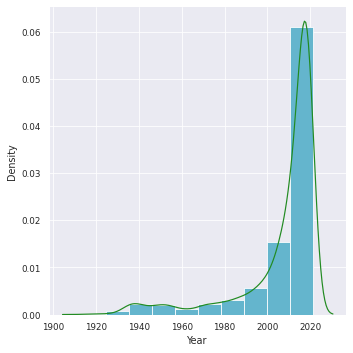

In [ ]:
#checking Distribution of years
x=df['Year']
sns.set()
sns.set_context("paper")
sns.displot(x,kind="kde",color='forestgreen') #sns.distplot(df['Year'])
plt.hist(x,density=True,color='c')
plt.show()

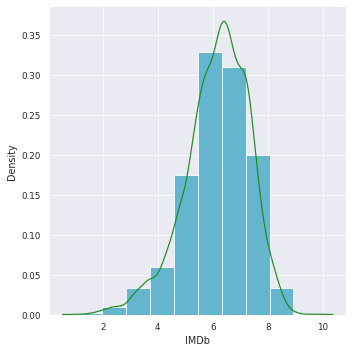

In [ ]:
# Distribution of IMDb Rating
x=df['IMDb']
sns.set()
sns.set_context("paper")
sns.displot(x,kind="kde",color='forestgreen') # `kind` must be one of ['hist', 'kde', 'ecdf']
plt.hist(x,density=True,color='c')
plt.show()

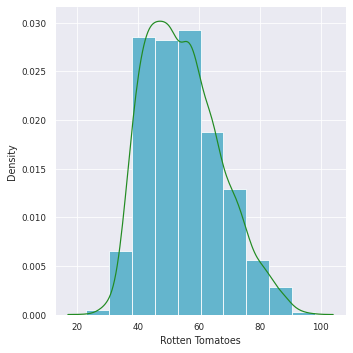

In [ ]:
# Distribution of Rotten Tomatoes Rating
x=df['Rotten Tomatoes']
sns.set()
sns.set_context("paper")
sns.displot(x,kind="kde",color='forestgreen') # `kind` must be one of ['hist', 'kde', 'ecdf']
plt.hist(x,density=True,color='c')
plt.show()

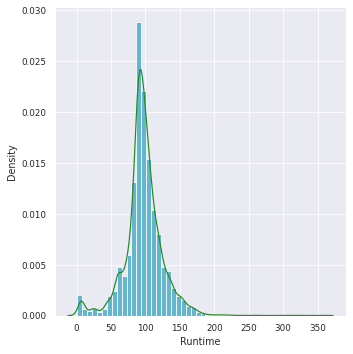

In [ ]:
# Distribution of Runtime
x=df['Runtime']
sns.set()
sns.set_context("paper")
sns.displot(x,kind="kde",color='forestgreen') # `kind` must be one of ['hist', 'kde', 'ecdf']
plt.hist(x,density=True,color='c',bins=50)
plt.show()

In [ ]:
# A function to calculate the movies in different Streaming platforms
# Si Count es True guarda el valor de del conteo de películas en la plataforma, si es falso imprime todo el texto
def m_cnt(plat, count=False):
    if count==False:
        print('Platform {} Count: {}'. format(plat, df[plat].sum()))
    else:
        return df[plat].sum()

In [ ]:
# Let's see count of movies/shows of each streaming platform
m_cnt('Netflix')
m_cnt('Hulu')
m_cnt('Prime Video')
m_cnt('Disney+')

Platform Netflix Count: 3325
Platform Hulu Count: 998
Platform Prime Video Count: 3799
Platform Disney+ Count: 819


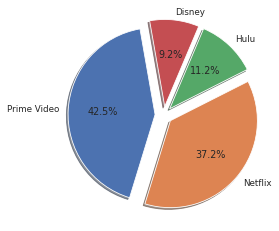

In [ ]:
# Movies on each platform
lab = 'Prime Video','Netflix', 'Hulu', 'Disney'
s = [m_cnt('Prime Video', count=True),
     m_cnt('Netflix', count=True),
     m_cnt('Hulu', count=True),
     m_cnt('Disney+', count=True)]

explode = (0.1, 0.1, 0.1, 0.1)

#plotting
fig1, ax1 = plt.subplots()
ax1.pie(s,
       labels = lab,
       autopct = '%1.1f%%', #Hace que imprima los porcentajes con la cantidad de decimales que uno ponga después del punto
       explode = explode, #Separa las partes del pie la distancia que se le haya dicho en el arreglo
       shadow = True,   #Es para hacer sombra para dar un efecto 3D
       startangle = 100) #Es la cantidad de grados que se gira la figura con respecto a la presentación original

ax1.axis = ('equal')
plt.show()

In [ ]:
#df['Genres'].str.split(',') #Me hace un arreglo con la cantidad de datos separados por el separador señalado
#df['Genres'].str.split(',').apply(pd.Series,1) #Me crea un data frame con un género de la película en cada columna
#g = df['Genres'].str.split(',').apply(pd.Series, 1).stack() #apila las columnas y crea sub indices
#g.index = g.index.droplevel(-1) #Me quita los indices de la fila 1

In [ ]:
##split the genres by ',' & then stack it one after the other for easy analysis.
g = df['Genres'].str.split(',').apply(pd.Series, 1).stack()
g.index = g.index.droplevel(-1)
# Assign name to column
g.name = 'Genres'
# delete column
del df['Genres'] 
# join new column with the existing dataframe
df_genres = df.join(g) #Me une todos los géneros con su respectiva película (Si hay más de un género la película se reescribe la cantidad de veces que sea necesaria) y se guarda en un nuevo dataframe 

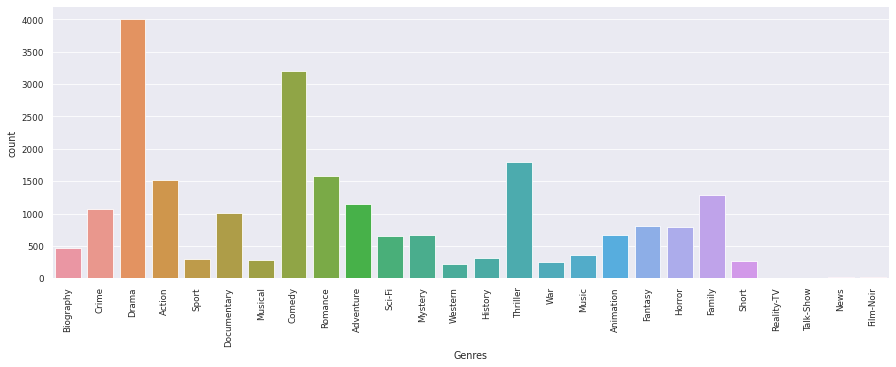

In [ ]:
# Count of movies according to genre
plt.figure(figsize=(15,5))
sns.countplot(x='Genres', data=df_genres) # sns.countplot(df_genres['Genres'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Split the Country by ',' & then stack it one after the other for easy analysis.
c = df['Country'].str.split(',').apply(pd.Series, 1).stack()
c.index = c.index.droplevel(-1)
# Assign name to column
c.name = 'Country'
# delete column
del df['Country']
# join new column with the existing dataframe
df_country = df.join(c)

In [ ]:
#df_country['Country'].value_counts() # Hace el conteo de cuántas veces se repite un mismo valor y los organiza de mayor a menor

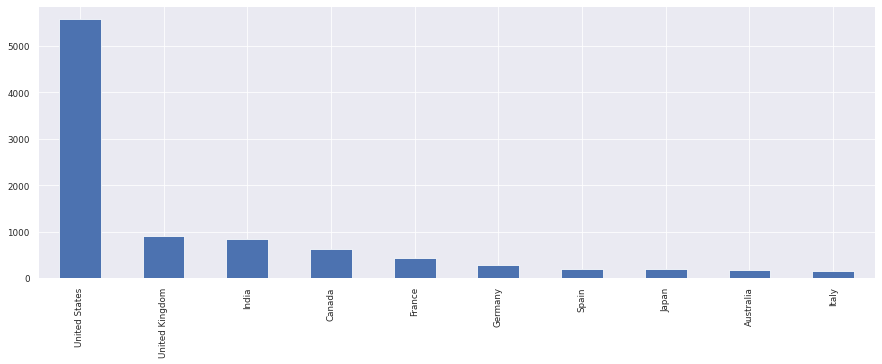

In [ ]:
# plotting top 10 country and movie count
df_country['Country'].value_counts()[:10].plot(kind='bar',figsize=(15,5))
plt.show()

In [ ]:
# perform stacking operation on language column
l = df['Language'].str.split(',').apply(pd.Series,1).stack()
l.index = l.index.droplevel(-1)
# Assign name to column
l.name = 'Language'
# delete column
del df['Language']
# join new column with the existing dataframe
df_language = df.join(l)

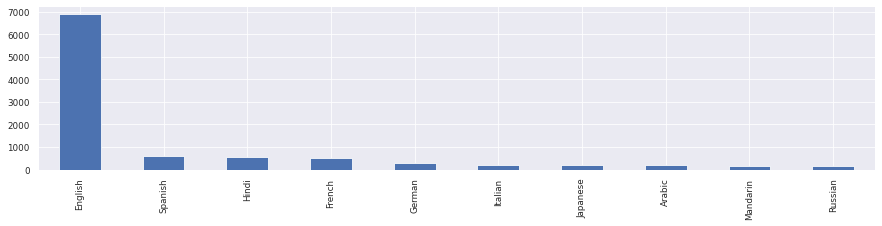

In [ ]:
# plotting top 10 Language and movie count
df_language['Language'].value_counts()[:10].plot(kind='bar',figsize=(15,3))
plt.show()

In [ ]:
# melting platform columns to create visualization
#Me agrupa en una columna todas las columnas que no meto en id_vars, y me da el valor que tenía en otra columna de value
df2 = pd.melt(df, id_vars=["ID","Title","Year","IMDb","Rotten Tomatoes","Type","Directors","Runtime"], var_name="platform")
df2 = df2[df2.value==1] #Me guarda unicamente los que tienen como valor 1, es decir, los que sí están en esa plataforma
df2.drop(columns=["value"],axis=1,inplace=True) #Elimina la columna value

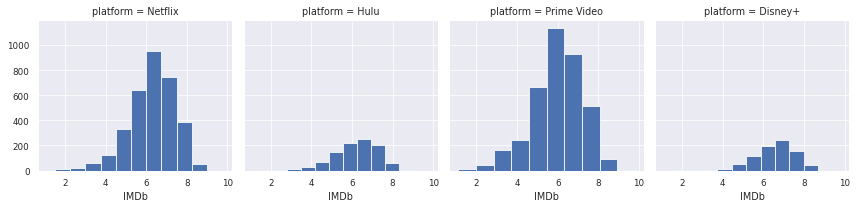

In [ ]:
# Distribution of IMDB rating in different platform
g = sns.FacetGrid(df2, col = "platform")
g.map(plt.hist, "IMDb")
plt.show()

In [ ]:
# Load dataset
df = pd.read_csv('MoviesOnStreamingPlatforms_updated.csv', index_col=0)
df.ID = df.ID.astype("object")

# melting platform columns to create visualization
df2 = pd.melt(df, id_vars=["ID","Title","Year","Age","IMDb","Rotten Tomatoes","Type","Runtime"], var_name="platform")
df2 = df2[df2.value==1]
df2.drop(columns=["value"],axis=1,inplace=True)

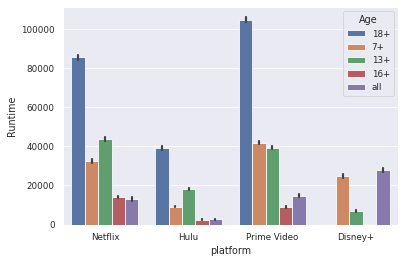

In [ ]:
# Total of runtime in different platform
ax = sns.barplot(x="platform", y="Runtime",hue="Age", estimator=sum, data=df2)

#**Recomendación de películas**

In [ ]:
df=pd.read_csv('MoviesOnStreamingPlatforms_updated.csv', index_col=0)

In [ ]:
#Finding Missing values in all columns
miss = pd.DataFrame(df.isnull().sum()) #Me guarda la suma de los valores nulos en cada columna que tiene el data frame
miss = miss.rename(columns={0:"miss_count"}) #Le pone título a la columna
miss["miss_%"] = (miss.miss_count/len(df.ID))*100 #Guarda porcentualmente cuántos datos faltantes hay por columna
miss

,miss_count,miss_%
ID,0,0.000000
Title,0,0.000000
Year,0,0.000000
Age,4177,43.899107
IMDb,206,2.165003
Rotten Tomatoes,7,0.073568
Netflix,0,0.000000
Hulu,0,0.000000
Prime Video,0,0.000000
Disney+,0,0.000000


In [ ]:
# Dropping values with missing % more than 50%
df.drop(['Age'], axis = 1, inplace=True)
# Dropping Na's from the following columns
df.dropna(subset=['IMDb','Rotten Tomatoes','Directors', 'Genres', 'Country', 'Language', 'Runtime'],inplace=True)
df.reset_index(inplace=True,drop=True)
# Converting into object type
df.ID = df.ID.astype("object")
df.Year = df.Year.astype("object")

In [ ]:
df['IMDb']=df['IMDb'].str.replace('/10','').astype("float64")
df['Rotten Tomatoes']=df['Rotten Tomatoes'].str.replace('/100','').astype("float64")

**1. Recomendación númerica**

Step-1: Select the numerical variable

In [ ]:
ndf = df.select_dtypes(include=['float64',"int64"])

Step-2: Scaling the numerical variable using a min-max scaler to reduce model complexity and training time.

In [ ]:
#importing minmax scaler
from sklearn import preprocessing

# Create MinMaxScaler Object
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Create dataframe after transformation
ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))

# assign column names
ndfmx.columns=ndf.columns

# Show initial 5 records
ndfmx.head()

,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Runtime
0,0.770115,1.000000,1.0,0.0,0.0,0.0,0.0,0.581006
1,0.839080,0.986667,1.0,0.0,0.0,0.0,0.0,0.446927
2,0.908046,0.960000,1.0,0.0,0.0,0.0,0.0,0.229050
3,0.804598,0.946667,1.0,0.0,0.0,0.0,0.0,0.622905
4,0.689655,0.946667,1.0,0.0,0.0,0.0,0.0,0.273743


Step-3: Compute similarity score using cosine similarity

Now, you will compute the similarity score using cosine similarity.

In [ ]:
# Import cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity
sig = cosine_similarity(ndfmx, ndfmx)

# Reverse mapping of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

In [ ]:
indices.head()

Title
The Irishman                                0
Dangal                                      1
David Attenborough: A Life on Our Planet    2
Lagaan: Once Upon a Time in India           3
To All the Boys I've Loved Before           4
dtype: int64

Step-4: Writing a function to get recommendations based on the similarity score

* The function takes two arguments, movie title, and similarity scores. It searches the index of the title corresponding to the original_titles index in our series of indices.
* Get the pairwise similarity scores of all the movies.
* Sorting the similarity scores in descending order and converting them into a list.
* Getting the top 10 movies scores and indices and returning the title of the top 10 movies from our data frame.

In [ ]:
def give_rec(title, sig=sig):

    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwise similarity scores
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return df['Title'].iloc[movie_indices]

In [ ]:
# Execute get_rec() function for getting recommendation
give_rec("Moana",sig = sig)

7947        The Greatest Showman
7942                  Home Alone
7936              Wreck-It Ralph
7938                     Tangled
7934                      Frozen
7955    Raya and the Last Dragon
7928                  Big Hero 6
7949                 Toy Story 4
7937               Incredibles 2
7941                        Luca
Name: Title, dtype: object

Here, recommended movies are not up to the mark. The reason behind this poor result is that you are using only movie ratings, movie runtimes, and platform variables. You can improve this by using other information such as genre, directors, and country.

**2. Recomendación númerica y categórica**

In [ ]:
df.head()

,ID,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,7.8,98.0,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2,Dangal,2016,8.4,97.0,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,3,David Attenborough: A Life on Our Planet,2020,9.0,95.0,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,8.1,94.0,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,6,To All the Boys I've Loved Before,2018,7.1,94.0,1,0,0,0,0,Susan Johnson,"Comedy,Drama,Romance",United States,English,99.0


Step-1

You will use textual columns into a single column then use tokenizer and TF-IDF Vectorizer to create a sparse matrix of all the words TF-IDF score. Then you will select and scale the numerical variables and add them into the sparse matrix. You need to perform the following steps for preprocessing:

* Selecting all object data types and storing them in a list.
* Removing ID and Title column.
* Joining all text/object columns using commas into a single column.
* Creating a tokenizer to remove unwanted elements from our data like symbols and numbers.
* Converting TfidfVector from the text After that we will do numerical columns pre-processing
* Selecting numerical variables into a data Frame
* Scaling Numerical variables using minmax scaler (0,1) range
* Adding numerical variables in the TF-IDF vectors sparse matrix using hstack function (hstack is used to add horizontal arrays into a sparse matrix).

In [ ]:
#the function performs all the important preprocessing steps
def preprocess(df):
    #combining all text columns
    # Selecting all object data type and storing them in list
    s = list(df.select_dtypes(include=['object']).columns)
    # Removing ID and Title column
    s.remove("Title")
    s.remove("ID")
    # Joining all text/object columns using commas into a single column
    df['all_text']= df[s].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

    # Creating a tokenizer to remove unwanted elements from our data like symbols and numbers
    token = RegexpTokenizer(r'[a-zA-Z]+')

    # Converting TfidfVector from the text
    cv = TfidfVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
    text_counts= cv.fit_transform(df['all_text'])

    # Aelecting numerical variables
    ndf = df.select_dtypes(include=['float64',"int64"])

    # Scaling Numerical variables
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

    # Applying scaler on our data and converting i into a data frame
    ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))
    ndfmx.columns=ndf.columns    

    # Adding our adding numerical variables in the TF-IDF vector
    IMDb = ndfmx.IMDb.values[:, None]
    X_train_dtm = hstack((text_counts, IMDb))
    Netflix = ndfmx.Netflix.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Netflix))
    Hulu = ndfmx.Hulu.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Hulu))
    Prime = ndfmx["Prime Video"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Prime))
    Disney = ndfmx["Disney+"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Disney))
    Runtime = ndfmx.Runtime.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Runtime))
    return X_train_dtm

Step-2: Applying the function to our data and creating a sparse matrix

In [ ]:
# Preprocessing data
mat =preprocess(df)
mat.shape

(8695, 8190)

Step-3: Again, applying Cosine Similarity to compute the similarity score

In [ ]:
# using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute the sigmoid kernel
sig2 = cosine_similarity(mat, mat)

# Reverse mapping of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

Step-4: Getting a recommendation from our improved system.

In [ ]:
give_rec("Moana",sig=sig2)

7991            The Princess and the Frog
8010                      Treasure Planet
7928                           Big Hero 6
8437             The Little Mermaid Live!
8083            The Great Mouse Detective
7997                                 Bolt
7951    Tinker Bell and the Lost Treasure
7955             Raya and the Last Dragon
7907                            Toy Story
7981                            Frozen II
Name: Title, dtype: object

In [ ]:
give_rec("Twilight",sig=sig2)

4468      Lords of Dogtown
629          Your Highness
908     Yours, Mine & Ours
155         Les Misérables
2922        Happy Go Lucky
565           Mother's Day
1376               One Day
316                   Home
1442                 Bliss
868              Rock On!!
Name: Title, dtype: object

In [ ]:
give_rec("Iron Man 3",sig=sig2)

7902                         Guardians of the Galaxy
7920                  Guardians of the Galaxy Vol. 2
7899                           Star Wars: A New Hope
7970                         Solo: A Star Wars Story
7935    Star Wars: Episode III - Revenge of the Sith
7909                   Star Wars: Return of the Jedi
8013                                     John Carter
7979    Star Wars: Episode II - Attack of the Clones
7919                    Rogue One: A Star Wars Story
7937                                   Incredibles 2
Name: Title, dtype: object

This time the recommender system works way better than the older system, which shows that by adding more relevant data like description text, a content-based recommender system can be improved significantly.

In [ ]:
from difflib import SequenceMatcher
SequenceMatcher(None, "Centro Comercial de La Villa (N)", "CC La Villa").ratio()
# 0.5116279069767442

0.5116279069767442

In [ ]:
from difflib import SequenceMatcher
BuscarTitulo='Tangled'
radios=np.zeros(len(df['Title']))

for i in range(0,len(df['Title'])):
  radios[i]=SequenceMatcher(None, df['Title'][i], BuscarTitulo).ratio()
dfBusqueda=df[['Title']]
dfBusqueda['Radios']=radios

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dfBusqueda.sort_values(by='Radios',ascending=False)[0:10]

,Title,Radios
7938,Tangled,1.000000
5662,The Eagle,0.625000
2911,Target,0.615385
4402,Jungle,0.615385
1,Dangal,0.615385
2149,Tragic Jungle,0.600000
2239,Bankrolled,0.588235
5412,Changeland,0.588235
4492,Tickled,0.571429
5689,Branded,0.571429


In [ ]:
dfBusqueda[dfBusqueda['Radios']>max(dfBusqueda['Radios']*0.7)].sort_values(by='Radios',ascending=False)

# **Búsqueda de películas**

In [ ]:
from difflib import SequenceMatcher

BuscarTitulo='Tangled'

radios=np.zeros(len(df['Title']))

for i in range(0,len(df['Title'])):
  radios[i]=SequenceMatcher(None, df['Title'][i], BuscarTitulo).ratio()
dfBusqueda=df[['Title']]
dfBusqueda['Radios']=radios

In [ ]:
dfBusqueda.sort_values(by='Radios',ascending=False)[0:10]

In [ ]:
give_rec("Moana",sig=sig2)

In [ ]:
give_rec("Moana",sig=sig)